In [10]:
# Load libraries
options(warn=-1)
source('../code/scMerge_helperFunctions.R')
library(SingleCellExperiment)
require(scMerge)
require(BiocParallel)
require(ggpubr)


Loading required package: ggpubr

Loading required package: ggplot2



In [5]:
# fres <- readRDS('../../data/tmp_scMerge.RDS')

In [7]:
# str(fres)

# Bridging Controls Multi-variate ANOVA Before & After Normalization

In order to determine if batch effects exist, the bridging controls can be used since they are approximately equally-distributed across both batches and are designed to serve as controls for the studies. 

The analyses below use multi-variate ANOVAs and graphical visualizations (i.e., PCA, T-SNE, and UMAP) to compare scMerge's normalization and batch correction. 

## Before Normalization M-ANOVA
To quantify the effect of batch effects on the scRNA samples, we can run a PCA on the gene expression and then take the 1st 5 components as "Y"-variables to predict against. And then, we can quantify how much the batch effect is "effective" at predicting the principal components (or a linear combination of the most varying genes). 

The formula below (in R-speak), runs a multi-variate anova against celltypes, batches, and celltype X batch interction

```cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch)```

and the summaries of the M-anova are displayed indicating degrees of freedom 

In [42]:
tmp <- fres$sce_object

BC.prior = scater::runPCA(tmp, exprs_values = "logcpm",ncomponents=5); 
PCs.prior<-data.frame(cbind(reducedDim(BC.prior),"cellType"=colData(tmp)$cellType,"batch"=colData(tmp)$batch))
PCs.prior[,1:5]<-apply(PCs.prior[,1:5],2,function(x){as.numeric(as.character(x))})
op <- options(contrasts = c("contr.helmert", "contr.poly"))
maov.prior<-manova(cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch),data=PCs.prior)
# maov.prior

# cat('\n\n\n\n\n\n')
summary(maov.prior, test ='Pillai')

                                       Df  Pillai approx F num Df den Df
as.factor(cellType)                    12 2.69933   945.76     60  48365
as.factor(batch)                        1 0.13933   313.05      5   9669
as.factor(cellType):as.factor(batch)   12 0.16626    27.73     60  48365
Residuals                            9673                               
                                        Pr(>F)    
as.factor(cellType)                  < 2.2e-16 ***
as.factor(batch)                     < 2.2e-16 ***
as.factor(cellType):as.factor(batch) < 2.2e-16 ***
Residuals                                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Before Normalization PCA 

Similarly, the cells below compare the 1st two principal components, coloring them by cell type and batch, respectively. 

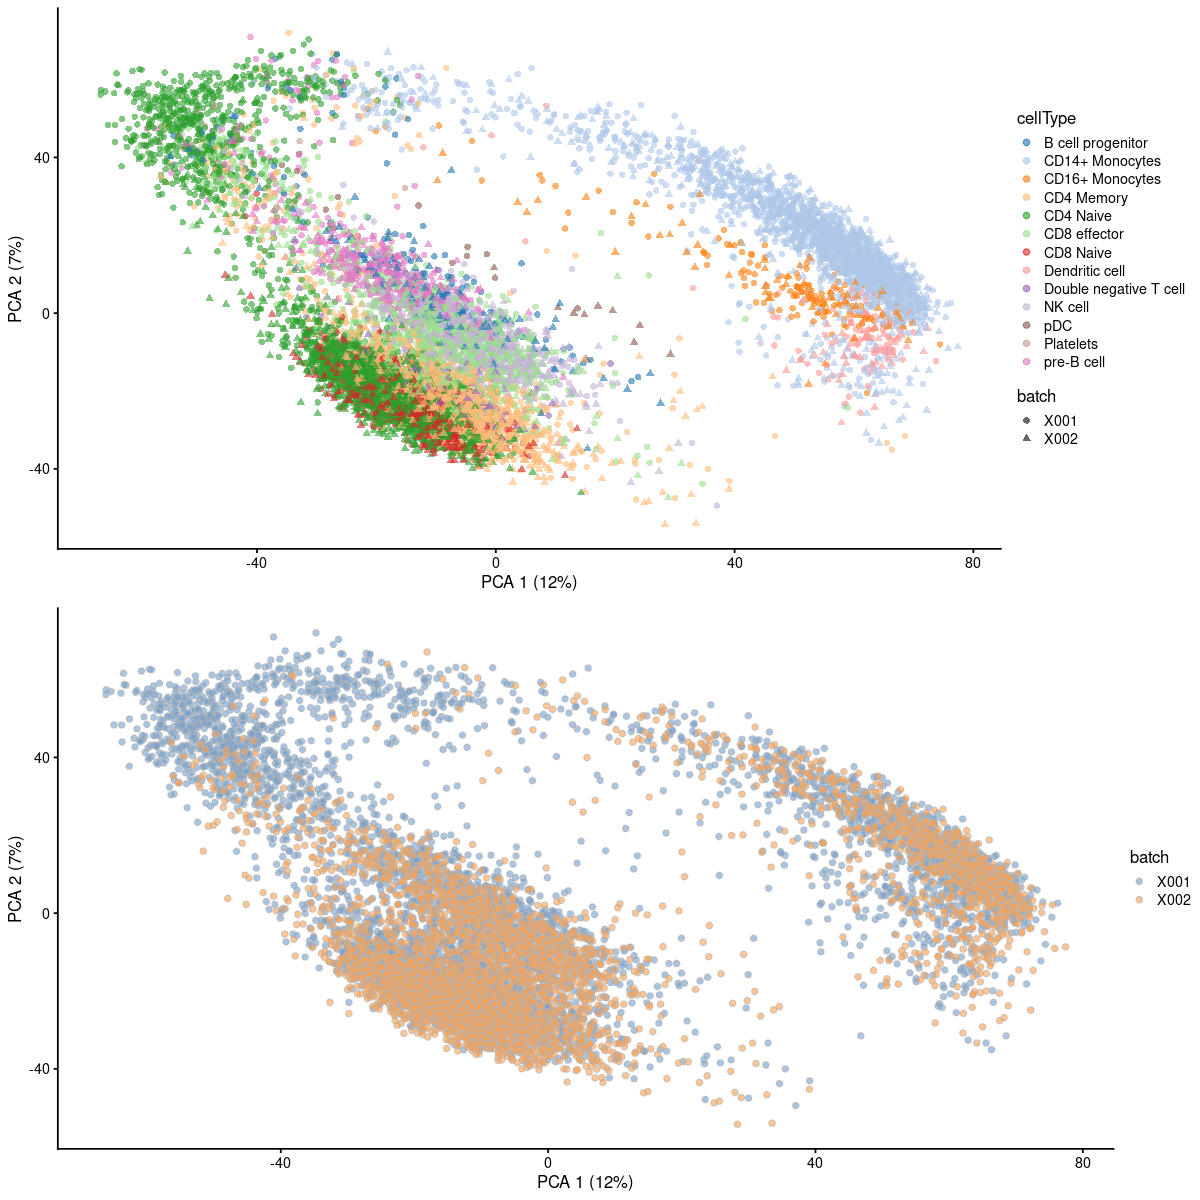

In [22]:
options(repr.plot.width=10, repr.plot.height=10)
p1<-scater::plotPCA(BC.prior, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotPCA(BC.prior, colour_by = "batch")
ggarrange(p1,p2, ncol=1)

## After Normalization: M-ANOVA

The normalization effect 

In [43]:
BC.post = scater::runPCA(tmp, exprs_values = "normalized",ncomponents=5); 
PCs.post<-data.frame(cbind(reducedDim(BC.post),"cellType"=colData(tmp)$cellType,"batch"=colData(tmp)$batch))
PCs.post[,1:5]<-apply(PCs.post[,1:5],2,function(x){as.numeric(as.character(x))})
op <- options(contrasts = c("contr.helmert", "contr.poly"))
maov.post<-manova(cbind(PC1,PC2,PC3,PC4,PC5) ~ as.factor(cellType)*as.factor(batch),data=PCs.post)
summary(maov.post, test='Pillai')
# cat('\n\n\n\n\n')

# maov.post[['coefficients']]

                                       Df Pillai approx F num Df den Df
as.factor(cellType)                    12 2.9234  1134.83     60  48365
as.factor(batch)                        1 0.0949   202.75      5   9669
as.factor(cellType):as.factor(batch)   12 0.1643    27.39     60  48365
Residuals                            9673                              
                                        Pr(>F)    
as.factor(cellType)                  < 2.2e-16 ***
as.factor(batch)                     < 2.2e-16 ***
as.factor(cellType):as.factor(batch) < 2.2e-16 ***
Residuals                                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## After Normalization PCA

The 1st two principal components are then plotted 

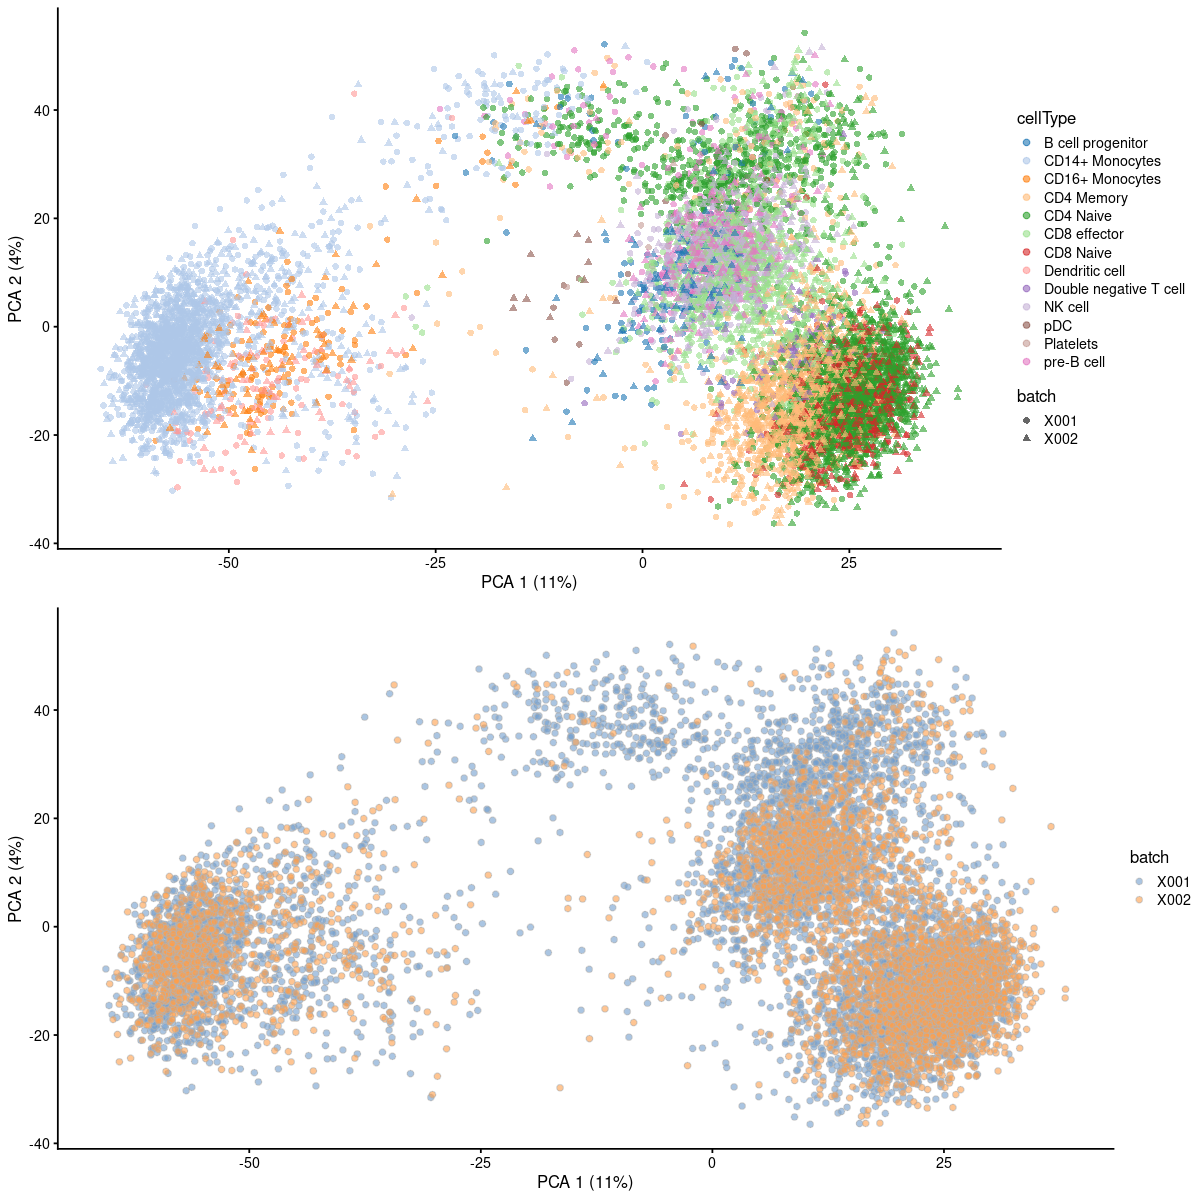

In [24]:
options(repr.plot.width=10, repr.plot.height=10)

p1<-scater::plotPCA(BC.post, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotPCA(BC.post, colour_by = "batch")
ggarrange(p1,p2, ncol=1)

# T-SNE Plots

In [45]:
set.seed(1000)
BC.prior <- scater::runTSNE(BC.prior, perplexity=50, dimred="PCA", exprs_values = "logcpm",  n_dimred=5)

p1<-scater::plotTSNE(BC.prior, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotTSNE(BC.prior, colour_by = "batch")

BC.post <- scater::runTSNE(BC.post, perplexity=50, dimred="PCA", exprs_values = "normalized",  n_dimred=5)

p3<-scater::plotTSNE(BC.post, colour_by = "cellType", shape_by = "batch")
p4<-scater::plotTSNE(BC.post, colour_by = "batch")


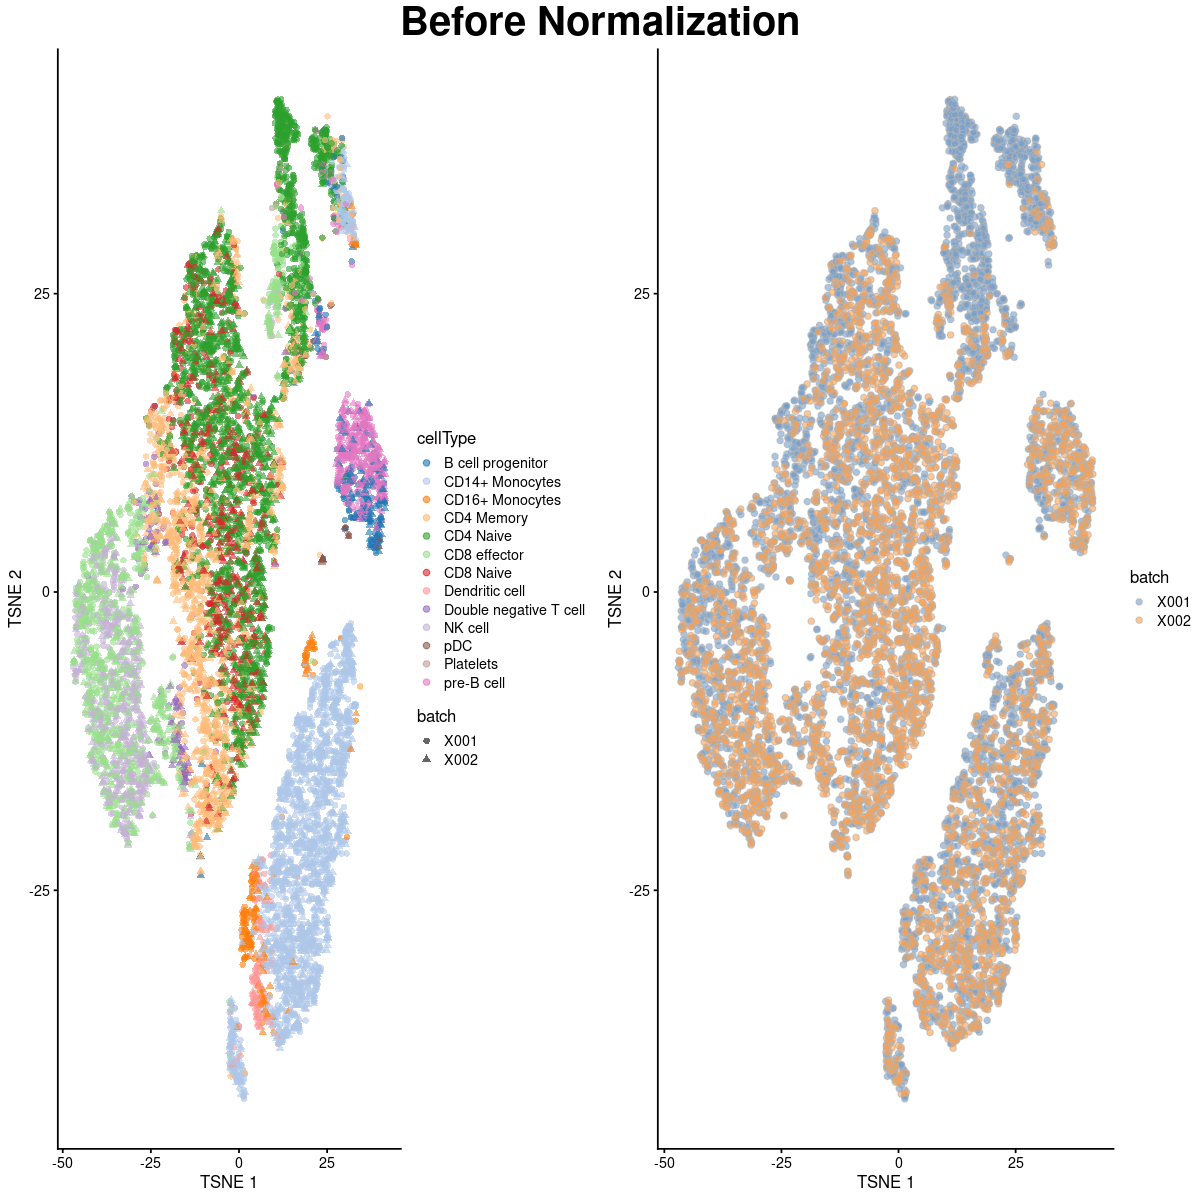

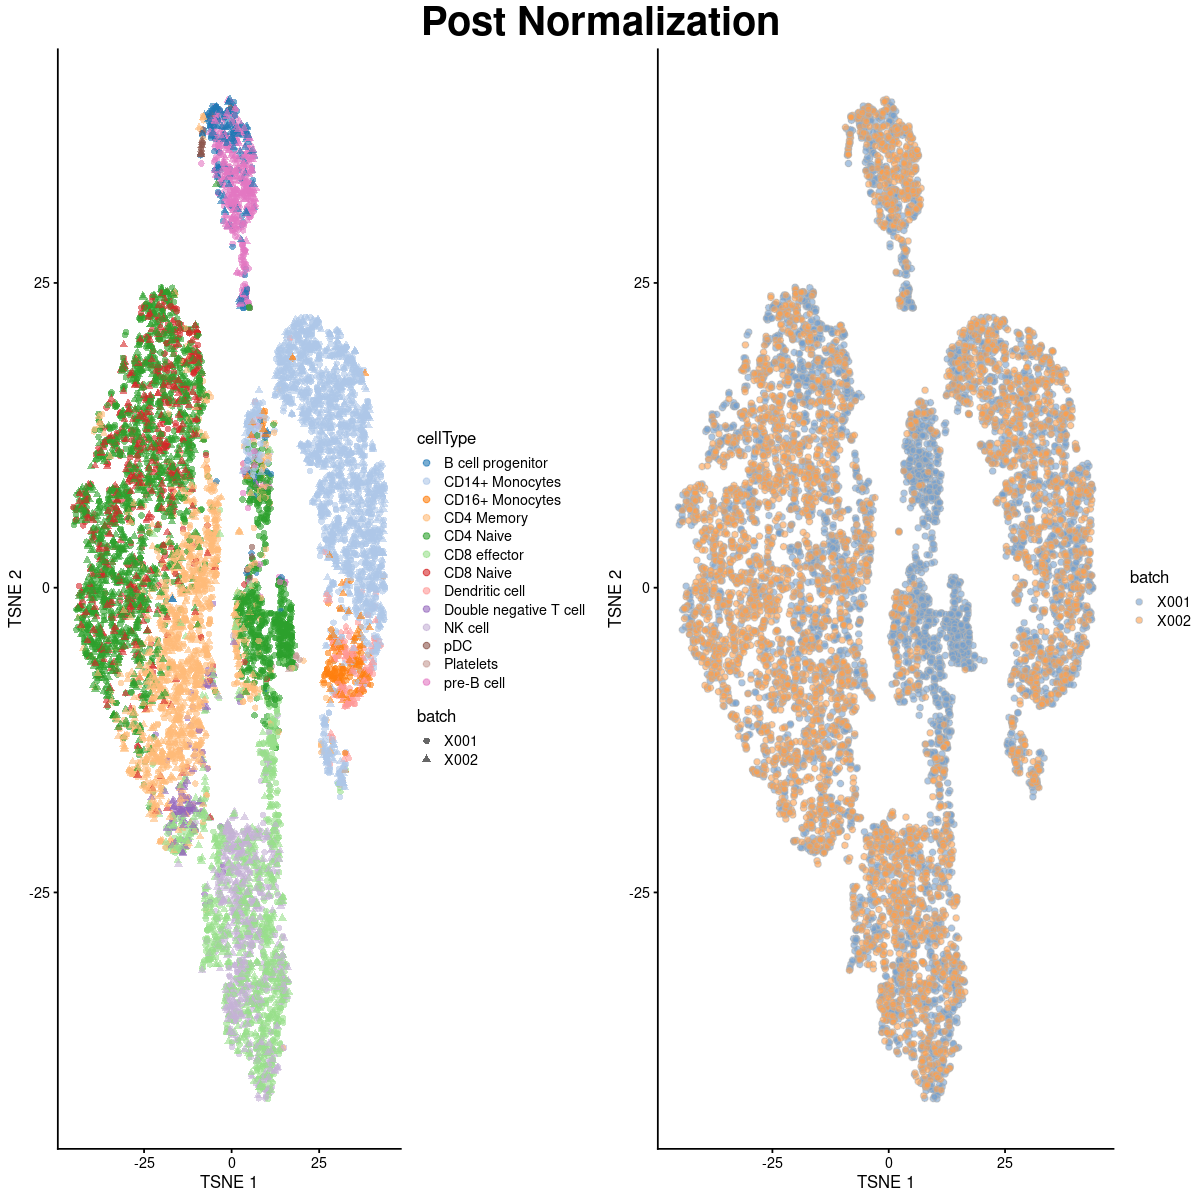

In [56]:
## Pre normalization
figure1 <- ggpubr::ggarrange(p1,p2, ncol=2) 
annotate_figure(figure1,
                top = text_grob("Before Normalization", color = "black", face = "bold", size = 24))

cat('\n\n')
figure2 <- ggpubr::ggarrange(p3,p4, ncol=2) 
annotate_figure(figure2,
                top = text_grob("Post Normalization", color = "black", face = "bold", size = 24))


# UMAP Plots

In [ ]:
BC.prior <- scater::runUMAP(BC.prior,  exprs_values = "logcpm",  n_dimred=5)

p1<-scater::plotUMAP(BC.prior, colour_by = "cellType", shape_by = "batch")
p2<-scater::plotUMAP(BC.prior, colour_by = "batch")

BC.post <- scater::runUMAP(BC.post, exprs_values = "normalized", use_dimred="PCA",  n_dimred=5) 
p3<-scater::plotUMAP(BC.post, colour_by = "cellType", shape_by = "batch")
p4<-scater::plotUMAP(BC.post, colour_by = "batch")

In [ ]:
## Pre normalization
figure1 <- ggpubr::ggarrange(p1,p2, ncol=2) 
annotate_figure(figure1,
                top = text_grob("Before Normalization", color = "black", face = "bold", size = 24))

cat('\n\n')
figure2 <- ggpubr::ggarrange(p3,p4, ncol=2) 
annotate_figure(figure2,
                top = text_grob("Post Normalization", color = "black", face = "bold", size = 24))
